# SAR Inference Demo

This notebook demonstrates how to generate images using a pretrained SAR model.

## Prerequisites
- PyTorch >= 2.0
- Pretrained checkpoints in `pretrained/` directory:
  - `FlexVAE.pth` - VAE checkpoint
  - `SARd16-epo179.pth` - SAR model checkpoint (depth 16)

## 1. Setup and Imports

In [35]:
import os
import random
import numpy as np
import torch
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
import time

# Disable default parameter init for faster model loading
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)

# Enable TF32 for faster computation
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 2. Configuration

Adjust these parameters to customize generation:

In [ ]:
# Model configuration
MODEL_TYPE = 'var'  # 'var' or 'scalear'
MODEL_DEPTH = 16    # 16, 20, 24, or 30

# Checkpoint paths
VAE_CKPT = 'pretrained/FlexVAE.pth'
VAR_CKPT = 'pretrained/SARd16-epo179.pth'

# Generation parameters
CFG_SCALE = 2.2     # Classifier-free guidance scale (higher = more class-specific)
TOP_K = 900         # Top-k sampling
TOP_P = 0.96        # Top-p (nucleus) sampling
SEED = 11           # Random seed for reproducibility
MAX_PATCH_NUM = 16  # Controls output resolution (16 = 256x256)

# ImageNet class labels to generate
# See: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
CLASS_LABELS = [
    980,  # volcano
    973,  # coral reef
    949,  # strawberry
    985,  # daisy
    291,  # lion
    388,  # giant panda
    95,   # jay
    33,   # loggerhead sea turtle
]

## 3. Load Models

In [37]:
# Build models
print(f"Loading {MODEL_TYPE} model with depth {MODEL_DEPTH}...")

if MODEL_TYPE == 'var':
    from models import build_vae_var
    vae, model = build_vae_var(
        V=8912, Cvae=32,
        device=device,
        num_classes=1000,
        depth=MODEL_DEPTH,
        shared_aln=False,
        vae_ckpt=VAE_CKPT,
        flash_if_available=True,
        fused_if_available=True,
    )
else:  # scalear
    from models import build_vae_scalear
    vae, model = build_vae_scalear(
        V=8912, Cvae=32,
        device=device,
        num_classes=1000,
        depth=MODEL_DEPTH,
        vae_ckpt=VAE_CKPT,
    )

# Load checkpoint
print(f"Loading checkpoint from {VAR_CKPT}...")
ckpt = torch.load(VAR_CKPT, map_location='cpu')

# Handle different checkpoint formats
if 'trainer' in ckpt:
    if MODEL_TYPE == 'scalear':
        model_state = ckpt['trainer'].get('scalear_wo_ddp', ckpt['trainer'].get('var_wo_ddp'))
    else:
        model_state = ckpt['trainer']['var_wo_ddp']
else:
    model_state = ckpt

# Handle attention bias mismatch
if MODEL_TYPE == 'var' and 'attn_bias_for_masking' in model.state_dict():
    model_state['attn_bias_for_masking'] = model.state_dict()['attn_bias_for_masking']

model.load_state_dict(model_state, strict=False)

# Set to eval mode
vae.eval()
model.eval()
for p in vae.parameters():
    p.requires_grad_(False)
for p in model.parameters():
    p.requires_grad_(False)

print("Models loaded successfully!")

Loading var model with depth 16...
VQ Model Parameters: 72,049,827
[vae_ckpt]: pretrained/FlexVAE.pth
number of parameters: 315.56M
Loading checkpoint from pretrained/sar-d16-ckpt-epo179.pth...
Models loaded successfully!


## 4. Generate Images

In [73]:
# Set random seed for reproducibility
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Define inference patch numbers
if MAX_PATCH_NUM == 16:
    infer_patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
elif MAX_PATCH_NUM == 13:
    infer_patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13)
else:
    infer_patch_nums = tuple(range(1, MAX_PATCH_NUM + 1))

B = len(CLASS_LABELS)
label_B = torch.tensor(CLASS_LABELS, device=device)

print(f"Generating {B} images...")
print(f"CFG Scale: {CFG_SCALE}")
print(f"Patch numbers: {infer_patch_nums}")

start_time = time.time()

with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16):
        if MODEL_TYPE == 'var':
            images = model.autoregressive_infer_cfg(
                vqvae=vae,
                B=B,
                label_B=label_B,
                infer_patch_nums=infer_patch_nums,
                cfg=CFG_SCALE,
                top_k=TOP_K,
                top_p=TOP_P,
                g_seed=SEED,
                more_smooth=False,
                max_pn=MAX_PATCH_NUM,
                used_llamagen_cfg=True,
            )
        else:  # scalear
            images = model.autoregressive_infer_cfg(
                vqvae=vae,
                B=B,
                label_B=label_B,
                infer_patch_nums=infer_patch_nums,
                cfg=CFG_SCALE,
                top_k=TOP_K,
                top_p=TOP_P,
                g_seed=SEED,
                cosine_n=4,
            )

elapsed = time.time() - start_time
print(f"\nGeneration completed in {elapsed:.2f}s")
print(f"Image shape: {images.shape}")
print(f"Resolution: {images.shape[-1]}x{images.shape[-1]}")

Generating 8 images...
CFG Scale: 2.2
Patch numbers: (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)

Generation completed in 0.73s
Image shape: torch.Size([8, 3, 256, 256])
Resolution: 256x256


## 5. Display Results

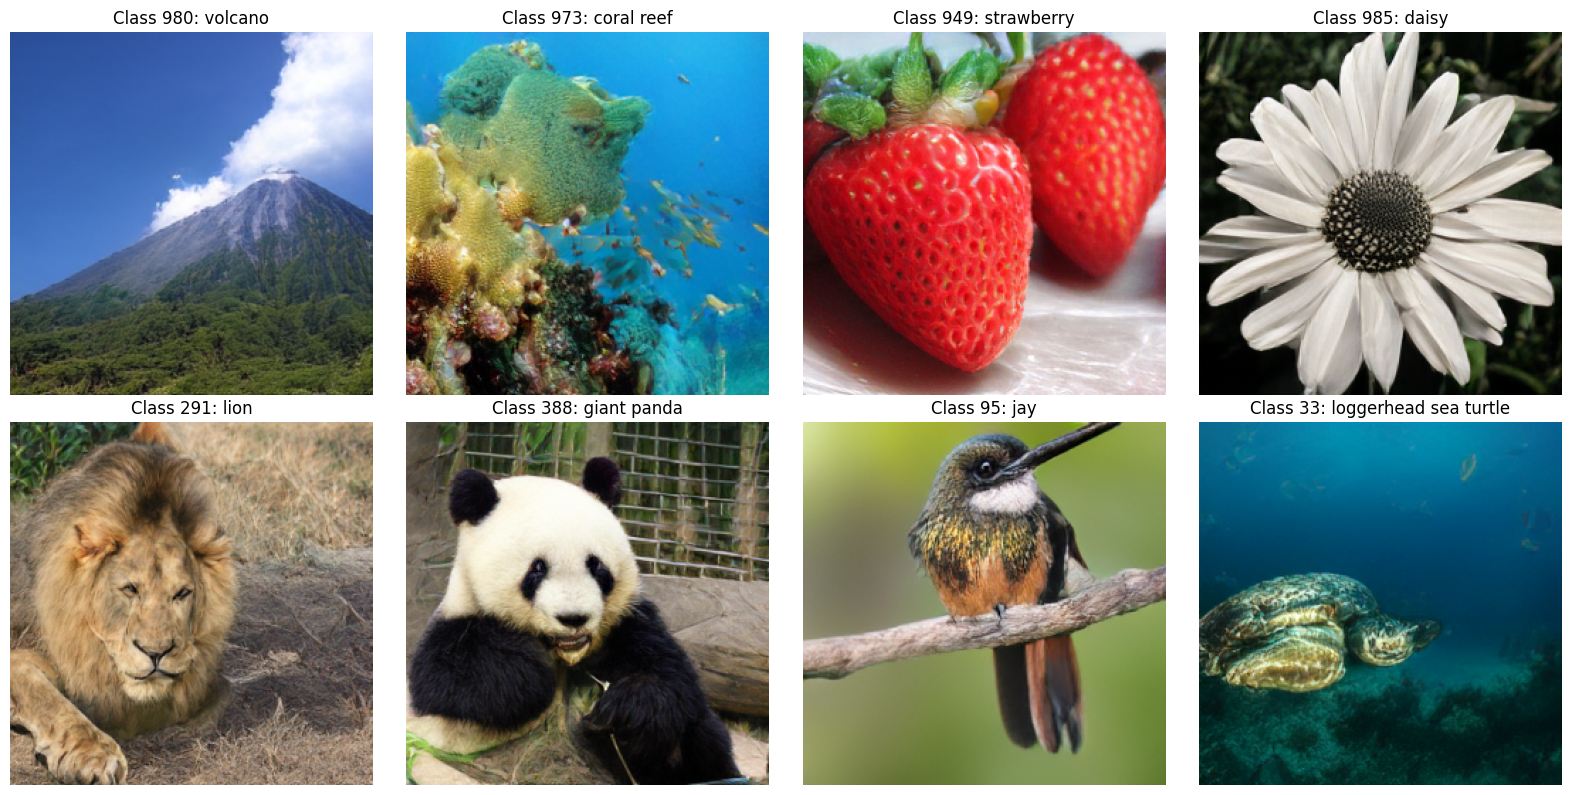

In [74]:
# Convert to displayable format
images_np = images.cpu().numpy().astype(np.float32)  # Ensure float32
images_np = (images_np + 1) / 2  # [-1, 1] -> [0, 1]
images_np = np.clip(images_np, 0, 1).astype(np.float32)
images_np = np.transpose(images_np, (0, 2, 3, 1))  # [B, H, W, C]

# ImageNet class names (subset for display)
class_names = {
    980: 'volcano',
    973: 'coral reef',
    949: 'strawberry',
    985: 'daisy',
    291: 'lion',
    388: 'giant panda',
    95: 'jay',
    33: 'loggerhead sea turtle',
}

# Display images in a grid
n_cols = min(4, B)
n_rows = (B + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = np.atleast_1d(axes).flatten()

for i, (img, label) in enumerate(zip(images_np, CLASS_LABELS)):
    axes[i].imshow(img)
    axes[i].set_title(f"Class {label}: {class_names.get(label, 'unknown')}")
    axes[i].axis('off')

# Hide empty subplots
for i in range(B, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 6. Save Images

In [75]:
# Save as grid
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, f'generated_cfg{CFG_SCALE}_seed{SEED}.png')
save_image(images, output_path, nrow=n_cols, normalize=True, value_range=(-1, 1))
print(f"Grid saved to: {output_path}")

# Save individual images
for i, (img, label) in enumerate(zip(images, CLASS_LABELS)):
    img_path = os.path.join(output_dir, f'class{label}_seed{SEED}.png')
    save_image(img, img_path, normalize=True, value_range=(-1, 1))
    print(f"Saved: {img_path}")

Grid saved to: outputs/generated_cfg2.2_seed11.png
Saved: outputs/class980_seed11.png
Saved: outputs/class973_seed11.png
Saved: outputs/class949_seed11.png
Saved: outputs/class985_seed11.png
Saved: outputs/class291_seed11.png
Saved: outputs/class388_seed11.png
Saved: outputs/class95_seed11.png
Saved: outputs/class33_seed11.png
